# 当我们谈论旅行的时候，我们在谈论什么？

- 知乎爬虫，关键词“旅行，旅游，景点”全部问题及回答
- 小红书IP被限制登录了，遂转战知乎
- 爬虫使用脚本MediaCrawler，语义情感分析使用SnowNLP（中文模型），停用词使用中文停用词表、哈工大停用词表、机器智能实验室停用词库
- 交互使用dash app，不确定是否适配网页版
- plotly rendering设置为notebook，网页端需要更改
- 所有图表颜色样式default，需要更改
- 目前进展： data description

In [11]:
import json
import pandas as pd
import altair as alt
alt.data_transformers.enable('vegafusion')
import numpy as np
from snownlp import SnowNLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
from plotly import io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Data Loading & Cleaning

In [2]:
# load data
comments_df = pd.read_json('data/comments.json', encoding='utf-8')
contents_df = pd.read_json('data/contents.json', encoding='utf-8')

In [3]:
# subselect
comments_df[['content', 'sub_comment_count', 'publish_time', 'content_id']]
contents_df = contents_df[['content_id', 'content_type', 'content_text', 'title', 'desc', 'created_time', 'voteup_count', 'comment_count']]

# drop na
comments_df = comments_df.dropna(subset=['content'])
contents_df = contents_df.dropna(subset=['content_text', 'desc'])

## Time Distribution

In [4]:
# time to date format
comments_df['publish_date'] = pd.to_datetime(comments_df['publish_time']).dt.date
contents_df['created_date'] = pd.to_datetime(contents_df['created_time']).dt.date

comments_df['year'] = pd.to_datetime(comments_df['publish_time']).dt.year
contents_df['year'] = pd.to_datetime(contents_df['created_time']).dt.year

In [8]:
# build dash app
app = dash.Dash(__name__)

# app layout
app.layout = html.Div([
    html.H1("Heatmap: Content & Comment"),
    dcc.Dropdown(
        id="dataset-dropdown",
        options=[
            {"label": "Comment Data", "value": "comments"},
            {"label": "Content Data", "value": "contents"}
        ],
        value="comments",
        placeholder="Select Dataset"
    ),
    dcc.Dropdown(
        id="year-dropdown",
        placeholder="Select Year"
    ),
    dcc.Graph(id="heatmap"),
])

# call: updated year selection
@app.callback(
    Output("year-dropdown", "options"),
    Output("year-dropdown", "value"),
    Input("dataset-dropdown", "value")
)
def update_year_options(selected_dataset):
    if selected_dataset == "comments":
        years = sorted(comments_df['year'].unique())
    else:
        years = sorted(contents_df['year'].unique())
    options = [{"label": str(year), "value": year} for year in years]
    return options, years[0]

# call: update heatmap
@app.callback(
    Output("heatmap", "figure"),
    Input("dataset-dropdown", "value"),
    Input("year-dropdown", "value")
)
def update_heatmap(selected_dataset, selected_year):
    if selected_dataset == "comments":
        filtered_df = comments_df[comments_df['year'] == selected_year]
        fig = px.density_heatmap(
            filtered_df,
            x="publish_date",
            y="sub_comment_count",
            labels={'publish_date': 'Date', 'sub_comment_count': 'Comment COunt'},
            nbinsx=365,
            title=f"Comment Distribution by Date - {selected_year}"
        )
    else:
        filtered_df = contents_df[contents_df['year'] == selected_year]
        fig = px.density_heatmap(
            filtered_df,
            x="created_date",
            y='voteup_count',
            labels={'created_date': 'Date', 'VoteUp Count': 'Likes'},
            nbinsx=365,
            title=f"Content Distribution by Date - {selected_year}"
        )
    fig.update_layout(
        xaxis=dict(tickformat="%b-%d", title="Date"),
        yaxis_title="Value",
        title_x=0.5,
    )
    return fig

# run app
if __name__ == '__main__':
    app.run_server(debug=True)


# Content Emotion Analysis

In [5]:
# snownlp emotion func
def analyze_sentiment(text):
    if text.strip():
        s = SnowNLP(text)
        return s.sentiments
    else:
        return None

### Content Analysis

In [6]:
# title desc analysis
contents_df['desc_sentiment'] = contents_df['desc'].apply(analyze_sentiment)

# content text analysis
# dropna
contents_df['content_text'] = contents_df['content_text'].fillna('')

contents_df['sentiment'] = contents_df['content_text'].apply(analyze_sentiment)

In [13]:
contents_df[['content_id', 'title', 'desc_sentiment','content_text', 'sentiment']].head()

,content_id,title,desc_sentiment,content_text,sentiment
0,2983182867,为什么国人的旅游方式普遍特别累？,0.315599,旅游就是累的。。。全世界旅游都是累的。。。因为旅游和度假是两个东西。。。举个例子好了，巴黎，...,0.999998
1,3554122723,如何看待朋友圈里一直在旅行的人？,0.999956,有个朋友，女孩，朋友圈全是旅行。仿佛她世界中只有风景，美照、美食和礼物。突然有一天，她的朋友...,1.000000
2,106211663,如何看待大学生频繁高消费旅行？,0.203454,1.我就是那种家庭条件一般，还喜欢频繁到处旅游，还喜欢发微博晒的大学生。2.我旅游没用多少家...,1.000000
3,633685987,你们去过哪些地方旅行？其中哪里让你感觉很值？,NaN,本回答发布于2019.3.27，最新更新于2020.5.21五一假期我又去大西北了，由于时间...,1.000000
4,31530201,旅行真的能使人改变吗？,1.000000,真的能，而且改变很大。 旅行让人变得谦逊、包容、乐观、坚韧，表现在外就是一种见过大世面的气质...,1.000000


### Comment Analysis

In [7]:
# comment analysis
comments_df['sentiment'] = comments_df['content'].apply(analyze_sentiment)

In [16]:
comments_df[['content', 'sentiment']].head()

,content,sentiment
0,对，我在武汉住了一个月都没把武汉景点逛完，每天睡醒都下午了。[思考][思考],0.184084
1,在厦门呆了一周，一个景点没去，主要活动就是和朋友约饭，没事干了就穿个沙滩裤、大拖鞋跑没人的海...,0.999154
2,最后一天想着来都来了，还是看看景点吧，果然，成了厦门之行里最后悔的一天[发呆],0.072324
3,国人多数是为了旅游而旅游打卡炫耀朋友圈的，是为了面子活着一天绕好几十个景点能不累么,0.111494
4,以我这些年旅游的经历来看，绝大部分城市景点和半数以上的自然景点根本没有去的必要[捂脸],0.642708


In [27]:
# visualization
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Content & Comment Emotion Analysis"),
    
    # year selection dropdown
    dcc.Dropdown(
        id="year-selector",
        options=[{'label': str(year), 'value': year} for year in contents_df['year'].unique()],
        value=contents_df['year'].min(),  # default min year
        multi=False
    ),
    
    dcc.Graph(id='content-sentiment-chart'),

    dcc.Graph(id='comment-sentiment-chart'),
])


# update by year
@app.callback(
    [Output('content-sentiment-chart', 'figure'),
     Output('comment-sentiment-chart', 'figure')],
    [Input('year-selector', 'value')]
)
def update_charts(selected_year):
    content_year_df = contents_df[contents_df['year'] == selected_year]
    comments_year_df = comments_df[comments_df['year'] == selected_year]

    # emotion recategory
    content_year_df['sentiment_category'] = content_year_df['desc_sentiment'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')
    
    #content
    content_sentiment_fig = px.histogram(
        content_year_df,
        x='desc_sentiment',
        color='sentiment_category',
        title=f"Content Emotion Analysis ({selected_year})",
        labels={'desc_sentiment': 'Emotion Value'},
        marginal="box"
    )

    # comment
    comment_sentiment_fig = px.scatter(
        comments_year_df,
        x='sentiment',
        y='content_id',
        color='sentiment',
        title=f"Comment Emotion Analysis ({selected_year})",
        labels={'sentiment': 'Emotion Value', 'content_id': 'Content ID'},
        hover_data=['content_id', 'publish_date', 'sentiment']
    )

    return content_sentiment_fig, comment_sentiment_fig


# launch
if __name__ == "__main__":
    app.run_server(debug=True)


/var/folders/p1/0z27bby16ws7ns0f26f1ssth0000gn/T/ipykernel_82137/1480811358.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p1/0z27bby16ws7ns0f26f1ssth0000gn/T/ipykernel_82137/1480811358.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
# histogram
# category func
def categorize_sentiment(df, sentiment_column):
    df['sentiment_category'] = pd.cut(df[sentiment_column], bins=[-float('inf'), 0.3, 0.7, float('inf')],
                                      labels=['Negative', 'Neutral', 'Positive'])
    return df

In [13]:
# content text
contents_df = categorize_sentiment(contents_df, 'sentiment') 
contents_text_hist = px.histogram(
    contents_df,
    x='sentiment_category',
    color='sentiment_category',
    title="Content Text 情绪分布",
    labels={'sentiment_category': '情绪类别'},
    marginal="box"
)

# content desc
contents_df = categorize_sentiment(contents_df, 'desc_sentiment')
contents_desc_hist = px.histogram(
    contents_df,
    x='sentiment_category',
    color='sentiment_category',
    title="Content Desc 情绪分布",
    labels={'sentiment_category': '情绪类别'},
    marginal="box"
)

# comment
comments_df = categorize_sentiment(comments_df, 'sentiment')
comments_hist = px.histogram(
    comments_df,
    x='sentiment_category',
    color='sentiment_category',
    title="Comment 情绪分布",
    labels={'sentiment_category': '情绪类别'},
    marginal="box"
)

contents_text_hist.show()
contents_desc_hist.show()
comments_hist.show()

In [43]:
# wordcloud

# func
# stopwords
def cut_words_without_stopwords(text, stopwords):
    words = jieba.cut(text)
    return [word for word in words if word not in stopwords and len(word) > 1]

def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

def generate_wordcloud(text_data, title, stopwords):
    # word split (CN)
    text = " ".join(cut_words_without_stopwords(" ".join(text_data), stopwords))
    
    wordcloud = WordCloud(
        font_path="CNFont.ttf", 
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        min_font_size=10
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

stopwords = load_stopwords("cn_stopwords.txt")

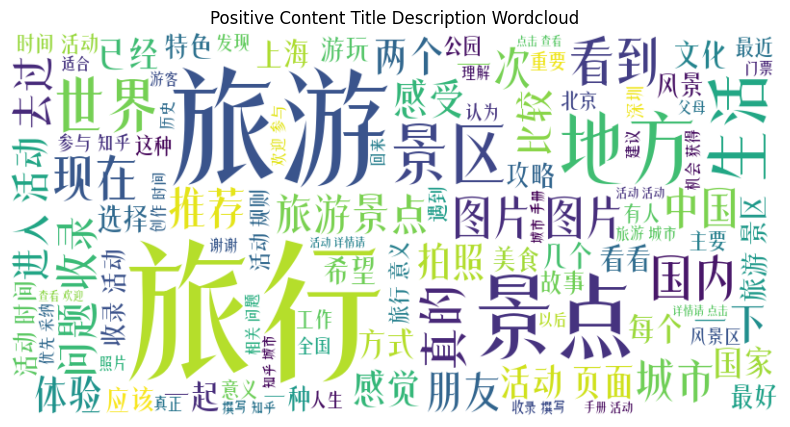

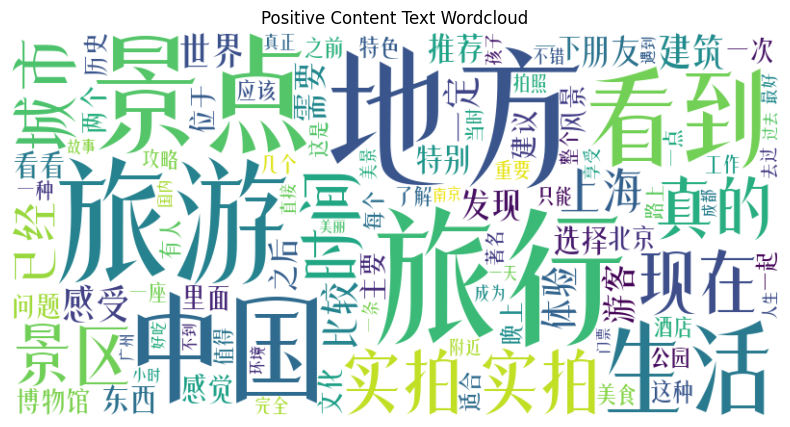

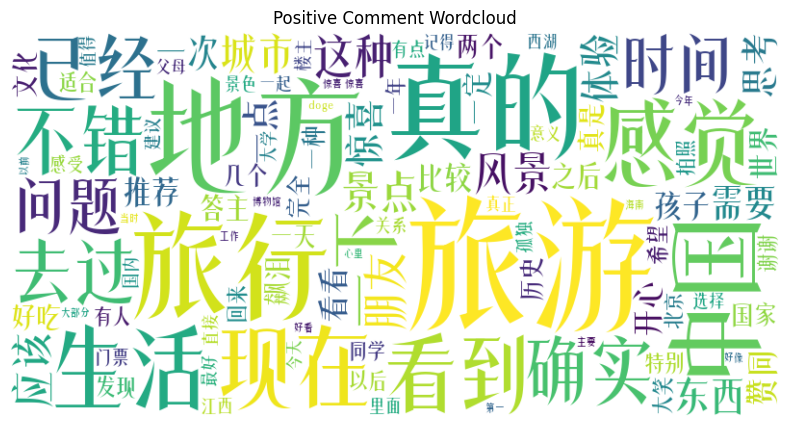

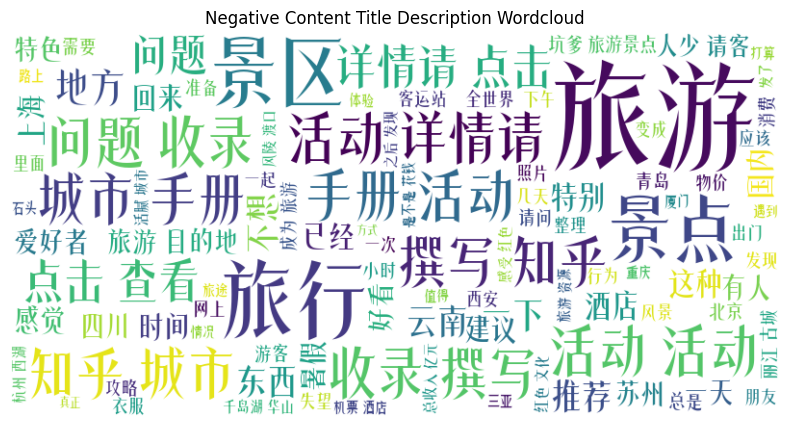

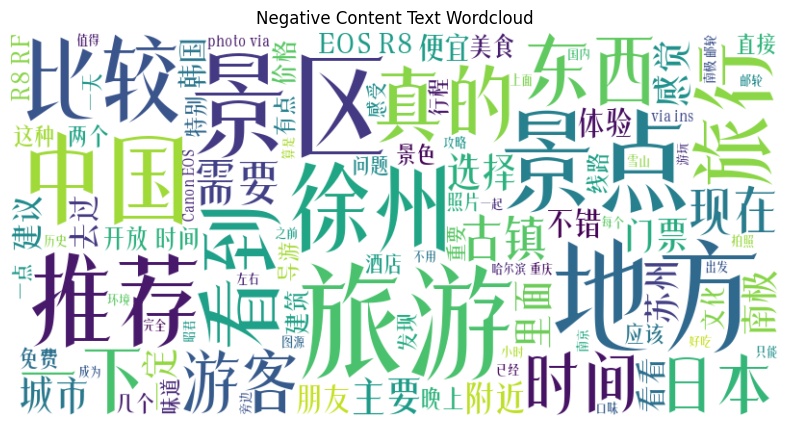

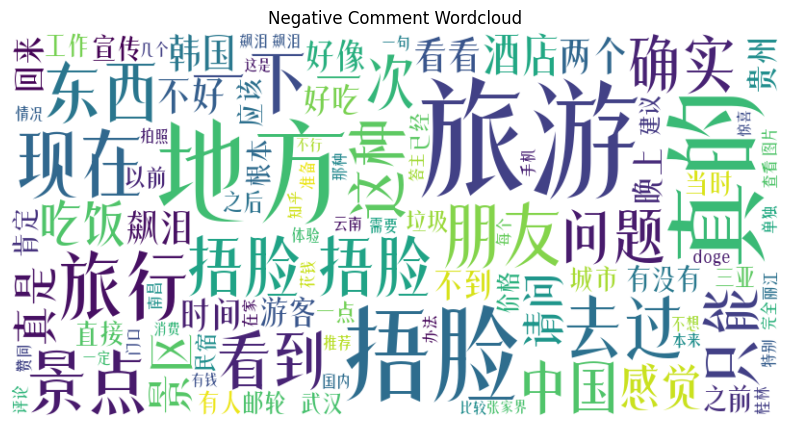

In [47]:
positive_content = contents_df[contents_df['desc_sentiment'] > 0.5]
negative_content = contents_df[contents_df['desc_sentiment'] <= 0.5]

positive_comment = comments_df[comments_df['sentiment'] > 0.5]
negative_comment = comments_df[comments_df['sentiment'] <= 0.5]

# wordcloud generate
generate_wordcloud(positive_content['desc'], "Positive Content Title Description Wordcloud", stopwords)
generate_wordcloud(positive_content['content_text'], "Positive Content Text Wordcloud", stopwords)
generate_wordcloud(positive_comment['content'], "Positive Comment Wordcloud", stopwords)

generate_wordcloud(negative_content['desc'], "Negative Content Title Description Wordcloud", stopwords)
generate_wordcloud(negative_content['content_text'], "Negative Content Text Wordcloud", stopwords)
generate_wordcloud(negative_comment['content'], "Negative Comment Wordcloud", stopwords)


## Modeling / further analysis